In [54]:
import os
import sys
import pandas as pd
import pyarrow
import fastparquet
import torch
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F

# 1. Load Raw Data

In [20]:
raw_data_dir = '../data/raw/'

reviews_file = os.path.join(raw_data_dir, 'reviews_dedup.parquet')

In [21]:
print(f"\nLoading reviews data from: {reviews_file}")
try:
    reviews_df = pd.read_parquet(reviews_file)
    print("Reviews DataFrame loaded successfully.")
    print("Shape:", reviews_df.shape)
    print("\nReviews Head:")
    print(reviews_df.head())
    print("\nReviews Info:")
    reviews_df.info(memory_usage='deep')
except FileNotFoundError:
    print(f"ERROR: Reviews file not found at {reviews_file}", file=sys.stderr)
except Exception as e:
    print(f"ERROR: Failed to load reviews file: {e}", file=sys.stderr)



Loading reviews data from: ../data/raw/reviews_dedup.parquet
Reviews DataFrame loaded successfully.
Shape: (15739967, 11)

Reviews Head:
                            user_id   book_id  \
0  8842281e1d1347389f2ab93d60773d4d  24375664   
1  8842281e1d1347389f2ab93d60773d4d  18245960   
2  8842281e1d1347389f2ab93d60773d4d   6392944   
3  8842281e1d1347389f2ab93d60773d4d  22078596   
4  8842281e1d1347389f2ab93d60773d4d   6644782   

                          review_id  rating  \
0  5cd416f3efc3f944fce4ce2db2290d5e       5   
1  dfdbb7b0eb5a7e4c26d59a937e2e5feb       5   
2  5e212a62bced17b4dbe41150e5bb9037       3   
3  fdd13cad0695656be99828cd75d6eb73       4   
4  bd0df91c9d918c0e433b9ab3a9a5c451       4   

                                         review_text  \
0  Mind blowingly cool. Best science fiction I've...   
1  This is a special book. It started slow for ab...   
2  I haven't read a fun mystery book in a while a...   
3  Fun, fast paced, and disturbing tale of murder...   
4  A

# 2. Filter Relevant Columns

In [22]:
columns_to_keep = ['user_id', 'book_id', 'rating']

print(f"Original columns: {reviews_df.columns.tolist()}")
print(f"Keeping columns: {columns_to_keep}")

reviews_df = reviews_df[columns_to_keep] 
print("Original DataFrame overwritten.")

print("\nFiltered DataFrame Info:")
reviews_df.info() 
print("\nFiltered DataFrame Head:")
print(reviews_df.head())

Original columns: ['user_id', 'book_id', 'review_id', 'rating', 'review_text', 'date_added', 'date_updated', 'read_at', 'started_at', 'n_votes', 'n_comments']
Keeping columns: ['user_id', 'book_id', 'rating']
Original DataFrame overwritten.

Filtered DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15739967 entries, 0 to 15739966
Data columns (total 3 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   user_id  object
 1   book_id  int64 
 2   rating   int64 
dtypes: int64(2), object(1)
memory usage: 360.3+ MB

Filtered DataFrame Head:
                            user_id   book_id  rating
0  8842281e1d1347389f2ab93d60773d4d  24375664       5
1  8842281e1d1347389f2ab93d60773d4d  18245960       5
2  8842281e1d1347389f2ab93d60773d4d   6392944       3
3  8842281e1d1347389f2ab93d60773d4d  22078596       4
4  8842281e1d1347389f2ab93d60773d4d   6644782       4


# 3. Mapp IDs to Integer Indices

In [35]:
print("Starting ID mapping...")

# Use factorize to get integer codes and the unique original IDs
user_codes, unique_user_ids = pd.factorize(reviews_df['user_id'])
# Add the new user index column to the DataFrame
reviews_df['user_idx'] = user_codes
# Create mapping dictionaries
user_id_to_idx = {user_id: idx for idx, user_id in enumerate(unique_user_ids)}
idx_to_user_id = {idx: user_id for user_id, idx in user_id_to_idx.items()}
# Get the total number of unique users
n_users = len(unique_user_ids)

print(f"Mapped {n_users} unique users to indices 0-{n_users-1}.")
print(f"Added 'user_idx' column.")

# Use factorize again for book_id
item_codes, unique_item_ids = pd.factorize(reviews_df['book_id'])
# Add the new item index column
reviews_df['item_idx'] = item_codes
# Create mapping dictionaries
item_id_to_idx = {item_id: idx for idx, item_id in enumerate(unique_item_ids)}
idx_to_item_id = {idx: item_id for item_id, idx in item_id_to_idx.items()}
# Get the total number of unique items
n_items = len(unique_item_ids)

print(f"Mapped {n_items} unique items (books) to indices 0-{n_items-1}.")
print(f"Added 'item_idx' column.")

print("\nDataFrame Info after mapping:")
reviews_df.info()
print("\nDataFrame Head after mapping:")
print(reviews_df.head())

print(f"\nTotal unique users: {n_users}")
print(f"Total unique items: {n_items}")
print(f"Total interactions: {len(reviews_df)}")

Starting ID mapping...
Mapped 465323 unique users to indices 0-465322.
Added 'user_idx' column.
Mapped 2080190 unique items (books) to indices 0-2080189.
Added 'item_idx' column.

DataFrame Info after mapping:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15739967 entries, 0 to 15739966
Data columns (total 5 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   user_id   object
 1   book_id   int64 
 2   rating    int64 
 3   user_idx  int64 
 4   item_idx  int64 
dtypes: int64(4), object(1)
memory usage: 600.4+ MB

DataFrame Head after mapping:
                            user_id   book_id  rating  user_idx  item_idx
0  8842281e1d1347389f2ab93d60773d4d  24375664       5         0         0
1  8842281e1d1347389f2ab93d60773d4d  18245960       5         0         1
2  8842281e1d1347389f2ab93d60773d4d   6392944       3         0         2
3  8842281e1d1347389f2ab93d60773d4d  22078596       4         0         3
4  8842281e1d1347389f2ab93d60773d4d   6644782       4         0      

# 4. Drop Negative Reviews

In [36]:
# Assuming 'reviews_df' contains 'user_id', 'book_id', 'rating', 'user_idx', 'item_idx'

# Define the rating threshold
min_rating_threshold = 4 

print(f"Original total interactions: {len(reviews_df)}")
print(f"Filtering to keep only ratings >= {min_rating_threshold}...")

# Create the new DataFrame by filtering based on the rating
positive_reviews_df = reviews_df[reviews_df['rating'] >= min_rating_threshold].copy()
# Using .copy() is recommended here to avoid SettingWithCopyWarning later if you modify it

print(f"Created 'positive_reviews_df' with {len(positive_reviews_df)} interactions.")

# --- Verify the result ---
print(f"\nMinimum rating in new DataFrame: {positive_reviews_df['rating'].min()}")
print(f"Maximum rating in new DataFrame: {positive_reviews_df['rating'].max()}")

print("\npositive_reviews_df Info:")
positive_reviews_df.info()
print("\npositive_reviews_df Head:")
print(positive_reviews_df.head())

# --- Optional: Check if filtering removed any users/items entirely ---
n_users_positive = positive_reviews_df['user_idx'].nunique()
n_items_positive = positive_reviews_df['item_idx'].nunique()

print(f"\nUnique users in positive interactions: {n_users_positive} (Original: {n_users})")
print(f"Unique items in positive interactions: {n_items_positive} (Original: {n_items})")

# Note: If n_users_positive < n_users or n_items_positive < n_items, 
# it means some users/items ONLY had low ratings and are now effectively removed
# from the positive interaction set. You might need to remap IDs if this is the case
# and your model strictly requires contiguous indices from 0 up to the new counts.
# However, often you can proceed using the original n_users/n_items for embedding layer sizes.

Original total interactions: 15739967
Filtering to keep only ratings >= 4...
Created 'positive_reviews_df' with 10515445 interactions.

Minimum rating in new DataFrame: 4
Maximum rating in new DataFrame: 5

positive_reviews_df Info:
<class 'pandas.core.frame.DataFrame'>
Index: 10515445 entries, 0 to 15739966
Data columns (total 5 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   user_id   object
 1   book_id   int64 
 2   rating    int64 
 3   user_idx  int64 
 4   item_idx  int64 
dtypes: int64(4), object(1)
memory usage: 481.4+ MB

positive_reviews_df Head:
                            user_id   book_id  rating  user_idx  item_idx
0  8842281e1d1347389f2ab93d60773d4d  24375664       5         0         0
1  8842281e1d1347389f2ab93d60773d4d  18245960       5         0         1
3  8842281e1d1347389f2ab93d60773d4d  22078596       4         0         3
4  8842281e1d1347389f2ab93d60773d4d   6644782       4         0         4
6  8842281e1d1347389f2ab93d60773d4d   9460786       4  

# 5. Construct Interaction Graph

In [37]:
# Assuming 'positive_reviews_df' is your filtered DataFrame 
# and 'n_users_positive', 'n_items_positive' might have been calculated

print("Constructing POSITIVE interaction graph edge index...")

# Extract user and item indices from the POSITIVE reviews DataFrame
user_indices_positive = positive_reviews_df['user_idx'].to_numpy()
item_indices_positive = positive_reviews_df['item_idx'].to_numpy()

# --- Create edge_index for GNNs (PyTorch Geometric format) ---

# Convert NumPy arrays to PyTorch tensors
user_tensor_positive = torch.tensor(user_indices_positive, dtype=torch.long)
item_tensor_positive = torch.tensor(item_indices_positive, dtype=torch.long)

# Stack them to create the edge_index format [2, num_positive_interactions]
# Overwriting the previous edge_index variable
edge_index = torch.stack([user_tensor_positive, item_tensor_positive], dim=0)

print(f"Created POSITIVE edge_index tensor with shape: {edge_index.shape}")
print(f"Number of POSITIVE edges (interactions): {edge_index.shape[1]}")

# Display a small sample of the new edge_index
print("\nSample POSITIVE edge_index columns (user_idx, item_idx):")
print(edge_index[:, :10]) # Show the first 10 edges

# This edge_index now represents the graph of high-rating interactions

Constructing POSITIVE interaction graph edge index...
Created POSITIVE edge_index tensor with shape: torch.Size([2, 10515445])
Number of POSITIVE edges (interactions): 10515445

Sample POSITIVE edge_index columns (user_idx, item_idx):
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  1,  3,  4,  6,  7,  8,  9, 11, 14]])


# 6. Visualization of Some Actual Interactions

Sampling neighborhood for 4 random users from POSITIVE interactions...
Number of users present in positive interactions: 429772
Sampled User Indices: [439920 358902 380302 156793]
Found 52 items connected to these users via positive interactions.
Sampled subgraph created with 56 nodes and 52 edges.


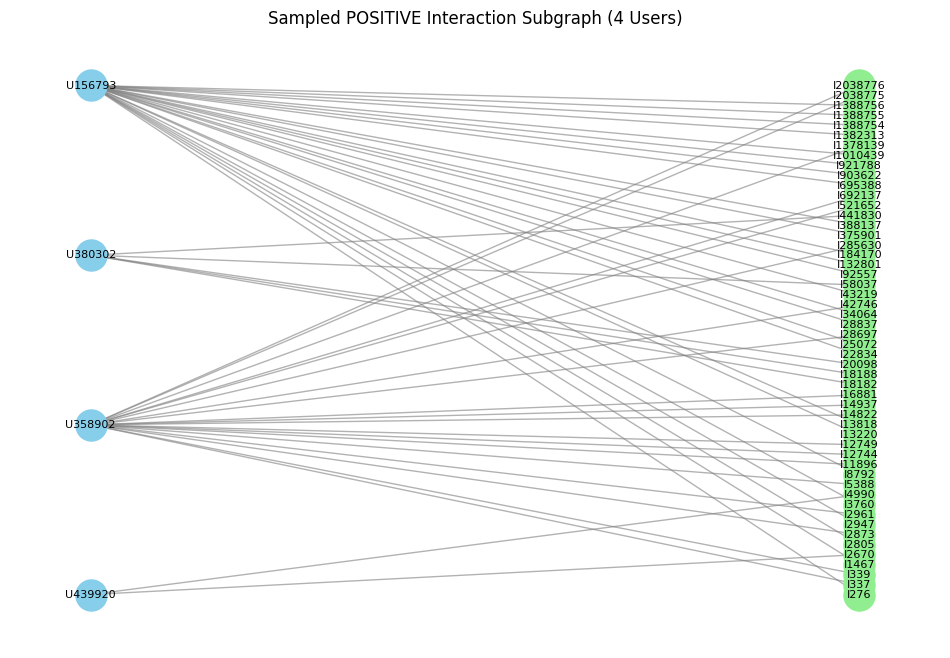

In [38]:
# --- Parameters for Sampling ---
num_users_to_sample = 4  # How many users to start with
# -----------------------------

print(f"Sampling neighborhood for {num_users_to_sample} random users from POSITIVE interactions...")

# --- Revised User Sampling ---
# It's better to sample from users known to have positive interactions
users_present_in_positive = torch.unique(edge_index[0,:]).numpy() # Get unique user indices from the positive edge_index
n_users_positive = len(users_present_in_positive)
print(f"Number of users present in positive interactions: {n_users_positive}")

if n_users_positive < num_users_to_sample:
    print(f"Warning: Requesting to sample {num_users_to_sample} users, but only {n_users_positive} have positive interactions. Sampling all available.")
    sampled_user_indices = users_present_in_positive
    num_users_to_sample = n_users_positive # Adjust for title
else:
    # Sample directly from the indices present in the positive set
    sampled_user_indices_indices = random.sample(range(n_users_positive), num_users_to_sample)
    sampled_user_indices = users_present_in_positive[sampled_user_indices_indices]

print(f"Sampled User Indices: {sampled_user_indices}")
# -----------------------------

# 2. Find interactions involving these users (using the POSITIVE edge_index)
# Convert edge_index to numpy for faster boolean indexing
edge_index_np = edge_index.numpy() 
user_col = edge_index_np[0, :]
item_col = edge_index_np[1, :]

# Find edges where the user is one of the sampled users
mask = np.isin(user_col, sampled_user_indices)
sampled_edges_np = edge_index_np[:, mask]

# 3. Identify unique items connected to these users
sampled_item_indices = np.unique(sampled_edges_np[1, :])
print(f"Found {len(sampled_item_indices)} items connected to these users via positive interactions.")

# 4. Create the Subgraph in NetworkX
G_sampled = nx.Graph()

# Node labels
sampled_user_nodes = [f'U{i}' for i in sampled_user_indices]
sampled_item_nodes = [f'I{i}' for i in sampled_item_indices]

G_sampled.add_nodes_from(sampled_user_nodes, bipartite=0)
G_sampled.add_nodes_from(sampled_item_nodes, bipartite=1)

# Add edges to the subgraph
for i in range(sampled_edges_np.shape[1]):
    u_idx = sampled_edges_np[0, i]
    i_idx = sampled_edges_np[1, i]
    G_sampled.add_edge(f'U{u_idx}', f'I{i_idx}')

print(f"Sampled subgraph created with {G_sampled.number_of_nodes()} nodes and {G_sampled.number_of_edges()} edges.")

# 5. Visualize the Subgraph
plt.figure(figsize=(12, 8)) # Adjust size as needed
pos = nx.bipartite_layout(G_sampled, sampled_user_nodes) 

nx.draw_networkx_nodes(G_sampled, pos, nodelist=sampled_user_nodes, node_color='skyblue', node_size=500)
nx.draw_networkx_nodes(G_sampled, pos, nodelist=sampled_item_nodes, node_color='lightgreen', node_size=500)
nx.draw_networkx_edges(G_sampled, pos, edge_color='gray', alpha=0.6)
nx.draw_networkx_labels(G_sampled, pos, font_size=8)

plt.title(f"Sampled POSITIVE Interaction Subgraph ({num_users_to_sample} Users)") # Updated title
plt.box(False)
plt.show()

# 7. Data Splitting - Random Interaction Split per User 

In [55]:
# --- Assumed variables ---
# positive_reviews_df: DataFrame with user_idx, item_idx, rating (>=4)
# edge_index: Tensor [2, num_positive_interactions] created from positive_reviews_df
# -------------------------

print("Splitting positive interactions into Train (70%), Validation (15%), and Test (15%) sets...")

# We'll work directly with the positive_reviews_df for easier splitting per user

# --- Step 1: Split into Train+Validation vs. Test (per user) ---

# Define the proportion for the test set
test_size_proportion = 0.15  # Hold out 15% for test

test_interactions_list = []
train_val_interactions_list = []

# Group by user
grouped_interactions = positive_reviews_df.groupby('user_idx')

print(f"Processing {grouped_interactions.ngroups} users for initial Train+Val/Test split...")

for user_idx, group in grouped_interactions:
    if len(group) < 3: 
        # Need at least 3 interactions to potentially split into train, val, test
        # Put all in train+validation for now (will be handled in next split)
        train_val_interactions_list.append(group)
        continue
        
    # Determine number of test samples for this user
    # Ensure at least 1 test sample if possible, up to 15%
    n_test_samples = max(1, int(len(group) * test_size_proportion)) 
    # Handle case where test would leave less than 2 for train+val
    if len(group) - n_test_samples < 2:
         if len(group) == 3: n_test_samples = 1 # Take 1 for test, leave 2 for train/val split
         # If len(group) is 2 or less, this case is handled by the initial if block

    # Split the group for this user
    train_val_group, test_group = train_test_split(group, test_size=n_test_samples, random_state=42) 
    
    test_interactions_list.append(test_group)
    train_val_interactions_list.append(train_val_group)

# Concatenate the lists back into DataFrames
train_val_df = pd.concat(train_val_interactions_list).reset_index(drop=True)
test_df = pd.concat(test_interactions_list).reset_index(drop=True)

print(f"Initial split: {len(train_val_df)} train+val interactions, {len(test_df)} test interactions.")

# --- Step 2: Split Train+Validation into Train vs. Validation (per user) ---

val_interactions_list = []
train_interactions_list = []

# Define the proportion for the validation set (relative to train+val set)
# Target is 15% validation out of original 100%. Test is 15%. So Train+Val is 85%.
# Proportion needed from Train+Val: 0.15 / (1.0 - 0.15) = 0.15 / 0.85 
val_size_proportion_relative = 0.15 / (1.0 - test_size_proportion) 

grouped_train_val = train_val_df.groupby('user_idx')

print(f"Processing {grouped_train_val.ngroups} users for Train/Validation split...")

for user_idx, group in grouped_train_val:
    if len(group) < 2:
        # If user has only 1 interaction left after test split, put it in train
        train_interactions_list.append(group)
        continue
        
    # Determine number of validation samples for this user
    # Ensure at least 1 validation sample if possible
    n_val_samples = max(1, int(len(group) * val_size_proportion_relative)) 
    # Handle case where val would leave 0 for train
    if len(group) - n_val_samples < 1:
        n_val_samples = len(group) - 1 # Ensure at least 1 left for train

    # Split the group for this user
    train_group, val_group = train_test_split(group, test_size=n_val_samples, random_state=42) 
    
    val_interactions_list.append(val_group)
    train_interactions_list.append(train_group)

# Concatenate the lists back into DataFrames
train_df = pd.concat(train_interactions_list).reset_index(drop=True)
val_df = pd.concat(val_interactions_list).reset_index(drop=True)

# --- Report Final Counts ---
print(f"\nFinal split: {len(train_df)} train, {len(val_df)} validation, {len(test_df)} test interactions.")
total_split = len(train_df) + len(val_df) + len(test_df)
original_total = len(positive_reviews_df)
print(f"Total interactions in splits: {total_split} (Original positive: {original_total})")
if total_split != original_total:
    print("Warning: Mismatch in total interactions after split - check logic for small groups.")

# Calculate percentages
train_perc = len(train_df) / original_total * 100
val_perc = len(val_df) / original_total * 100
test_perc = len(test_df) / original_total * 100
print(f"Split percentages: Train={train_perc:.2f}%, Validation={val_perc:.2f}%, Test={test_perc:.2f}%")

# --- Step 3: Create edge_index tensors for each set ---

def create_edge_index_from_df(df):
    # Ensure indices are valid before creating tensor
    if df.empty:
        return torch.empty((2, 0), dtype=torch.long)
    user_indices = df['user_idx'].to_numpy()
    item_indices = df['item_idx'].to_numpy()
    user_tensor = torch.tensor(user_indices, dtype=torch.long)
    item_tensor = torch.tensor(item_indices, dtype=torch.long)
    return torch.stack([user_tensor, item_tensor], dim=0)

train_edge_index = create_edge_index_from_df(train_df)
val_edge_index = create_edge_index_from_df(val_df)
test_edge_index = create_edge_index_from_df(test_df)

print(f"\nTrain edge_index shape: {train_edge_index.shape}")
print(f"Validation edge_index shape: {val_edge_index.shape}")
print(f"Test edge_index shape: {test_edge_index.shape}")

# You now have train_edge_index, val_edge_index, and test_edge_index (approx 70/15/15)

Splitting positive interactions into Train (70%), Validation (15%), and Test (15%) sets...
Processing 429772 users for initial Train+Val/Test split...
Initial split: 9015979 train+val interactions, 1499466 test interactions.
Processing 429772 users for Train/Validation split...

Final split: 7442865 train, 1573114 validation, 1499466 test interactions.
Total interactions in splits: 10515445 (Original positive: 10515445)
Split percentages: Train=70.78%, Validation=14.96%, Test=14.26%

Train edge_index shape: torch.Size([2, 7442865])
Validation edge_index shape: torch.Size([2, 1573114])
Test edge_index shape: torch.Size([2, 1499466])


# 8.1 Model Architecture - Setting up Embedding Layers

In [74]:
# --- Imports ---
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys # Keep for error messages

print("Attempting PyG imports...")
try:
    from torch_geometric.nn import GCNConv
    from torch_geometric.utils import degree # Use degree for manual normalization
    print(f"Successfully imported GCNConv: {GCNConv}") 
    print(f"Successfully imported degree: {degree}") 
    PYG_AVAILABLE = True
except ImportError as e:
    print(f"ERROR: PyTorch Geometric import failed: {e}", file=sys.stderr)
    print("Please ensure torch_geometric is installed correctly.", file=sys.stderr)
    PYG_AVAILABLE = False
    # Define dummy classes/functions if needed for code structure to pass syntax check
    class GCNConv: pass 
    def degree(*args, **kwargs): print("Dummy degree called"); return torch.ones(1) 
print(f"PYG_AVAILABLE set to: {PYG_AVAILABLE}")
# --- End Imports ---

class NGCF(nn.Module):
    def __init__(self, n_users, n_items, embed_dim, n_layers=3):
        super(NGCF, self).__init__()

        if not PYG_AVAILABLE:
             # This check remains important
             raise ImportError("torch_geometric ('GCNConv', 'degree') could not be imported.")

        self.n_users = n_users
        self.n_items = n_items
        self.embed_dim = embed_dim
        self.n_layers = n_layers

        print(f"Initializing NGCF (LightGCN style) model with {self.n_layers} layers...")

        self.user_embedding = nn.Embedding(num_embeddings=self.n_users, embedding_dim=self.embed_dim)
        self.item_embedding = nn.Embedding(num_embeddings=self.n_items, embedding_dim=self.embed_dim)
        
        self.gcn_conv = GCNConv(in_channels=self.embed_dim, 
                                out_channels=self.embed_dim, 
                                normalize=False, # Set normalize=False as we do it manually
                                add_self_loops=False, 
                                bias=False) 
        
        nn.init.xavier_uniform_(self.user_embedding.weight)
        nn.init.xavier_uniform_(self.item_embedding.weight)
        print("Initialized user and item embedding layers.")

    def get_embeddings(self, edge_index):
        user_embed_0 = self.user_embedding.weight
        item_embed_0 = self.item_embedding.weight
        x0 = torch.cat([user_embed_0, item_embed_0], dim=0)
        
        all_layer_embeddings = [x0] 
        
        # --- Prepare Edge Index AND Manual Normalization ---
        row, col = edge_index
        num_nodes = self.n_users + self.n_items
        adjusted_col = col + self.n_users # Offset item indices
        
        # Create full adjacency (user->item and item->user)
        full_edge_index = torch.cat([
            torch.stack([row, adjusted_col], dim=0), 
            torch.stack([adjusted_col, row], dim=0) 
        ], dim=1)
        
        # --- Manually Calculate Symmetric Normalization Weights ---
        # 1. Calculate degree D for all nodes
        deg = degree(full_edge_index[0], num_nodes=num_nodes, dtype=x0.dtype).clamp(min=1)
        # 2. Calculate D^-0.5
        deg_inv_sqrt = deg.pow(-0.5)
        # 3. Calculate normalization factor for each edge: norm_e = (D_src)^-0.5 * (D_dst)^-0.5
        norm_edge_weight = deg_inv_sqrt[full_edge_index[0]] * deg_inv_sqrt[full_edge_index[1]]
        # --- End Manual Normalization ---

        current_embeddings = x0
        for layer in range(self.n_layers):
            # Note: We pass the *full* edge index here, GCNConv's propagate handles it
            next_embeddings = self.gcn_conv.propagate(
                full_edge_index, 
                x=current_embeddings, 
                edge_weight=norm_edge_weight, 
                size=(num_nodes, num_nodes) # Pass size as a tuple (N, N)
            )
            all_layer_embeddings.append(next_embeddings)
            current_embeddings = next_embeddings 
            
        final_embeddings_stack = torch.stack(all_layer_embeddings, dim=0)
        final_embeddings = torch.mean(final_embeddings_stack, dim=0) 
       
        final_user_embed, final_item_embed = torch.split(
            final_embeddings, [self.n_users, self.n_items], dim=0
        )
        
        return final_user_embed, final_item_embed

    # --- The 'forward' method remains the same as before ---
    def forward(self, edge_index, users_idx=None, pos_items_idx=None, neg_items_idx=None):
        # ... (keep the existing forward method logic) ...
        final_user_embed, final_item_embed = self.get_embeddings(edge_index)
        if users_idx is None or pos_items_idx is None or neg_items_idx is None:
            return final_user_embed, final_item_embed
        users_emb_final = final_user_embed[users_idx]
        pos_items_emb_final = final_item_embed[pos_items_idx]
        neg_items_emb_final = final_item_embed[neg_items_idx]
        pos_scores = torch.sum(users_emb_final * pos_items_emb_final, dim=1)
        neg_scores = torch.sum(users_emb_final * neg_items_emb_final, dim=1)
        user_emb_initial = self.user_embedding(users_idx)
        item_emb_pos_initial = self.item_embedding(pos_items_idx)
        item_emb_neg_initial = self.item_embedding(neg_items_idx)
        return pos_scores, neg_scores, user_emb_initial, item_emb_pos_initial, item_emb_neg_initial



# --- Define Hyperparameters ---
embed_dim = 64  # Or another value like 32, 128
n_layers = 3    # Or another value like 2, 4

print(f"Using Hyperparameters: embed_dim={embed_dim}, n_layers={n_layers}") 

# --- Example Usage ---
# (Make sure the cell defining embed_dim and n_layers above has run)
model = NGCF(n_users=n_users, n_items=n_items, embed_dim=embed_dim, n_layers=n_layers)

# Example 1: Get all final embeddings (for inference/evaluation)
# This might be slow if the graph/embeddings are large
print("\nTesting Example 1: Get all embeddings...")
try:
    # Make sure edge_index is on the right device if using GPU later
    # final_u_emb_all, final_i_emb_all = model(train_edge_index.to(device)) 
    final_u_emb_all, final_i_emb_all = model(train_edge_index) 
    print("Successfully computed all embeddings.")
    print("Final User Embedding Shape:", final_u_emb_all.shape) 
    print("Final Item Embedding Shape:", final_i_emb_all.shape)
except Exception as e:
    print(f"Error during Example 1: {e}")


# Example 2: Get scores for a batch during training (BPR)
print("\nTesting Example 2: Get batch scores...")
try:
    users_batch = torch.tensor([0, 0, 1], dtype=torch.long) # Example user indices
    pos_items_batch = torch.tensor([1, 3, 2], dtype=torch.long) # Corresponding positive items
    # Ensure negative items are within the valid item index range [0, n_items-1]
    neg_items_batch = torch.tensor([10 % n_items, 20 % n_items, 30 % n_items], dtype=torch.long) 
    
    # Make sure all inputs are on the right device if using GPU later
    # pos_scores, neg_scores, _, _, _ = model(train_edge_index.to(device), users_batch.to(device), pos_items_batch.to(device), neg_items_batch.to(device))
    pos_scores, neg_scores, _, _, _ = model(train_edge_index, users_batch, pos_items_batch, neg_items_batch)
    
    print("Successfully computed batch scores.")
    print("Example Positive Scores:", pos_scores)
    print("Example Negative Scores:", neg_scores)
except Exception as e:
    print(f"Error during Example 2: {e}")


Attempting PyG imports...
Successfully imported GCNConv: <class 'torch_geometric.nn.conv.gcn_conv.GCNConv'>
Successfully imported degree: <function degree at 0x57e74e5c0>
PYG_AVAILABLE set to: True
Using Hyperparameters: embed_dim=64, n_layers=3
Initializing NGCF (LightGCN style) model with 3 layers...
Initialized user and item embedding layers.

Testing Example 1: Get all embeddings...
Successfully computed all embeddings.
Final User Embedding Shape: torch.Size([465323, 64])
Final Item Embedding Shape: torch.Size([2080190, 64])

Testing Example 2: Get batch scores...
Successfully computed batch scores.
Example Positive Scores: tensor([7.0941e-07, 2.1081e-06, 1.7957e-06], grad_fn=<SumBackward1>)
Example Negative Scores: tensor([ 2.1069e-06,  2.5700e-06, -7.7715e-07], grad_fn=<SumBackward1>)


# 8.2 Model Architecture - Training

In [75]:
import torch
import torch.nn.functional as F # For the sigmoid/logsigmoid function

def calculate_bpr_loss(pos_scores, neg_scores, 
                       user_emb_initial=None, pos_item_emb_initial=None, neg_item_emb_initial=None, 
                       lambda_reg=1e-4): # Regularization strength hyperparameter
    """
    Calculates the BPR loss.

    Args:
        pos_scores (torch.Tensor): Scores for positive user-item pairs (batch_size).
        neg_scores (torch.Tensor): Scores for negative user-item pairs (batch_size).
        user_emb_initial (torch.Tensor, optional): Initial user embeddings (batch_size, embed_dim).
        pos_item_emb_initial (torch.Tensor, optional): Initial positive item embeddings (batch_size, embed_dim).
        neg_item_emb_initial (torch.Tensor, optional): Initial negative item embeddings (batch_size, embed_dim).
        lambda_reg (float, optional): L2 regularization strength. Defaults to 1e-4.

    Returns:
        torch.Tensor: The calculated BPR loss value (scalar).
    """
    
    # BPR Core Loss: -log(sigmoid(pos_score - neg_score))
    # Using F.logsigmoid(diff) is numerically more stable than log(sigmoid(diff))
    difference = pos_scores - neg_scores
    bpr_core_loss = -torch.mean(F.logsigmoid(difference)) # Mean over the batch

    # L2 Regularization Loss (if initial embeddings are provided)
    reg_loss = 0.0
    if user_emb_initial is not None and pos_item_emb_initial is not None and neg_item_emb_initial is not None:
        # Calculate L2 norm squared for each embedding type and sum
        reg_loss = (user_emb_initial.norm(2).pow(2) + 
                    pos_item_emb_initial.norm(2).pow(2) + 
                    neg_item_emb_initial.norm(2).pow(2))
        
        # Normalize by batch size (or number of users/items in batch, common practice)
        batch_size = pos_scores.shape[0] 
        reg_loss = lambda_reg * (reg_loss / batch_size) 

    # Total Loss
    total_loss = bpr_core_loss + reg_loss
    
    return total_loss

# --- Example Usage (within a hypothetical training step) ---
# Assume model, train_edge_index, users_batch, pos_items_batch, neg_items_batch are defined
# 
# pos_scores, neg_scores, user_emb_0, item_emb_pos_0, item_emb_neg_0 = model(
#     train_edge_index, users_batch, pos_items_batch, neg_items_batch
# )
#
# loss = calculate_bpr_loss(
#     pos_scores, neg_scores, 
#     user_emb_0, item_emb_pos_0, item_emb_neg_0, 
#     lambda_reg=1e-4 # Example value
# )
#
# print(f"Calculated BPR Loss: {loss.item()}") 
# loss.backward() # Backpropagate
# optimizer.step() # Update weights